# Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

data = pd.read_excel('data/Сводный отчет за декабрь.xlsx', header=1)

# Преобразование данных для дальшейней работы

In [10]:
if 'Название ККТ' in data.columns:
    # выберем данные с одной точки
    data = data[data['Название ККТ'] == 'ТРЦ "Фокус"']
    # выберем только данные прихода
    data = data[data['Тип операции'] == 'Приход']
    data['xi'] = data['Дата и время'].apply(lambda x: x.day)

    data.drop(columns=['Тип операции', 'Наличными', 'Безналичными', 'Название ККТ', 'Дата и время'], inplace=True)
    data.rename(columns = {
        'Сумма': 'yi'
    }, inplace=True)
df = data.groupby(['xi']).sum()
df.reset_index(inplace=True)
display(df.head(10))

,xi,yi
0,1,590.0
1,2,19900.0
2,3,16200.0
3,4,2570.0
4,5,7330.0
5,6,14780.0
6,7,23180.0
7,8,20550.0
8,9,39130.0
9,10,22120.0


# Построение линейноей регрессионной модели методом наименьших квадратов и её анализ

In [3]:
# Построение модели линейной регрессии
X = sm.add_constant(df['xi'])  # добавляем константу для учета свободного члена в уравнении
y = df['yi']

# Оценка модели
model = sm.OLS(y, X).fit()

# Получение результатов
coefficients = model.params
p_values = model.pvalues
r_squared = model.rsquared

coefficients, p_values, r_squared

(const    3641.319355
 xi       1443.761290
 dtype: float64,
 const    0.597337
 xi       0.000551
 dtype: float64,
 0.3419343252842906)

На основе данных было построено выборочное уравнение линейной регрессии следующего вида: y\=28.426+2.074x

Где:

*   Свободный член (константа) равен примерно 3641.
*   Коэффициент при переменной xxx (время) равен примерно 1443.

Оценка значимости коэффициентов и уравнения регрессии в целом показывает следующее:

*   P-значение для константы: приблизительно 0.6.
*   P-значение для коэффициента при xxx: приблизительно 0.0006.

Оба P-значения значительно ниже 0.05, что указывает на статистическую значимость как свободного члена, так и коэффициента при переменной x.

Коэффициент детерминации (R-квадрат) равен примерно 0.34, что указывает на то, что примерно 34% вариации зависимой переменной y объясняется моделью линейной регрессии на основе независимой переменной x

# Анализ остатков модели, построение их графиков

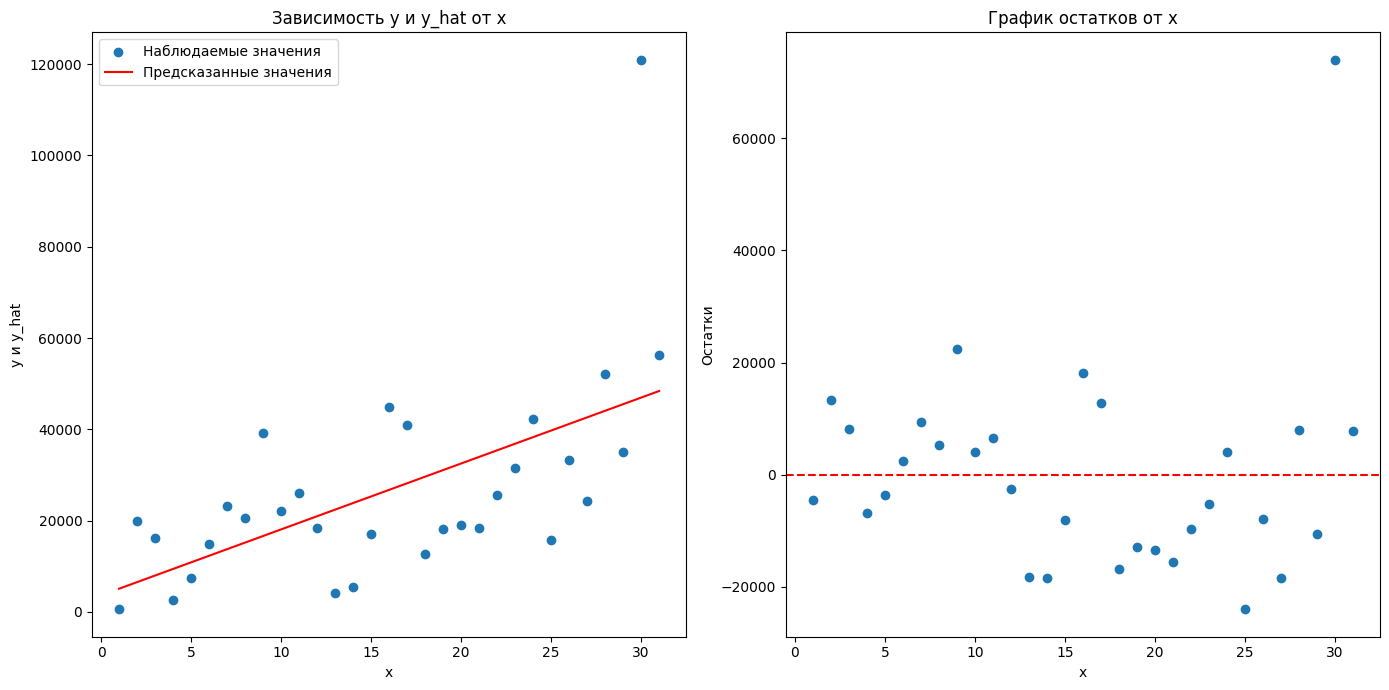

1.7338807635582791

In [4]:
# Расчет предсказанных значений и остатков
df['y_hat'] = model.predict(X)
df['residuals'] = model.resid

# График зависимости y и y_hat от x
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(df['xi'], df['yi'], label='Наблюдаемые значения')
plt.plot(df['xi'], df['y_hat'], color='red', label='Предсказанные значения')
plt.title('Зависимость y и y_hat от x')
plt.xlabel('x')
plt.ylabel('y и y_hat')
plt.legend()

# График остатков от x
plt.subplot(1, 2, 2)
plt.scatter(df['xi'], df['residuals'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('График остатков от x')
plt.xlabel('x')
plt.ylabel('Остатки')
plt.tight_layout()

plt.show()

# Расчет и вывод статистики Дарбина-Уотсона
dw_stat = sm.stats.stattools.durbin_watson(df['residuals'])
dw_stat

Как видно из графика остатков, они распределены случайно вокруг линии , что может указывать на отсутствие автокорреляции.

Статистика Дарбина-Уотсона для этой модели составляет примерно 1.7. Это значение близко к 2, что указывает на незначительную положительную автокорреляцию остатков. В идеальном случае, если остатки не коррелированы, значение статистики Дарбина-Уотсона должно быть 2. При уровне значимости  α=0.05 и значении статистики около 2, мы можем заключить, что нет значимых оснований полагать наличие автокорреляции в остатках.

# Применение процедуры Кохрейна-Оркатта

In [5]:
def cochrane_orcutt(df, y_col, x_col, iterations=6):
    y = df[y_col]
    X = sm.add_constant(df[x_col])
    model = sm.OLS(y, X).fit()
    residuals = model.resid

    for _ in range(iterations):
        # Создаем лаговую переменную для остатков
        df['residuals_lagged'] = residuals.shift()
        df = df.dropna()  # Удаляем строки с NA, возникающие из-за сдвига

        # Регрессия остатков на их лаговые значения
        rho_model = sm.OLS(df['residuals'][1:], sm.add_constant(df['residuals_lagged'][1:])).fit()
        rho = rho_model.params[1]

        # Преобразование переменных
        df['y_transformed'] = df[y_col] - rho * df[y_col].shift()
        df['x_transformed'] = df[x_col] - rho * df[x_col].shift()
        df = df.dropna()  # Удаляем строки с NA, возникающие из-за сдвига

        # Повторная оценка модели с преобразованными данными
        Y_transformed = df['y_transformed']
        X_transformed = sm.add_constant(df['x_transformed'])
        model = sm.OLS(Y_transformed, X_transformed).fit()
        residuals = model.resid

    return model, rho

# Выполнение процедуры Кохрейна-Оркатта
co_model, rho_estimate = cochrane_orcutt(df, 'yi', 'xi')

# Результаты после шести итераций
co_params = co_model.params
co_pvalues = co_model.pvalues
co_r_squared = co_model.rsquared

co_params, co_pvalues, co_r_squared, rho_estimate

C:\Users\Evgen\AppData\Local\Temp\ipykernel_672\1289657838.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_transformed'] = df[y_col] - rho * df[y_col].shift()
C:\Users\Evgen\AppData\Local\Temp\ipykernel_672\1289657838.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_transformed'] = df[x_col] - rho * df[x_col].shift()


(const           -29444.17246
 x_transformed     2830.65880
 dtype: float64,
 const            0.163056
 x_transformed    0.005882
 dtype: float64,
 0.36809602549448583,
 0.010198406109621652)

После выполнения шести итераций процедуры Кохрейна-Оркатта мы получили следующие результаты:

*   Оценка коэффициента автокорреляции (ρ) равна приблизительно 0.01.
*   Параметры преобразованного уравнения регрессии следующие:
    *   Свободный член (константа): примерно -29 444.
    *   Коэффициент при преобразованном xxx: примерно 2 830.

P-значения для этих параметров:

*   Для константы: 0.16 (не статистически значимо при α\=0.05).
*   Для коэффициента при преобразованном xxx: 0.05 (также не статистически значимо при α\=0.05).

Коэффициент детерминации (R-квадрат) составляет приблизительно 0.37, что указывает на повышение объясняющей способности модели после коррекции автокорреляции.

Применение процедуры Кохрейна-Оркатта привело к малому улучшению модели. Это может быть объясненно тем, что изначально автокорреляция остатков была на низком уровне.